# Assignment 9
## Due June 26th
### names:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import linalg as LA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from scipy.stats import expon
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import LinearRegression, LogisticRegression
import networkx as nx

np.random.seed(42)

## Exercise 1

In [2]:
X, y = load_breast_cancer(return_X_y=True)
shuffled_idx = np.random.permutation(len(X))
X, y = X[shuffled_idx], y[shuffled_idx]
len_test = len(X) // 3 * 2
X_train, X_test = X[:len_test], X[len_test:]
y_train, y_test = y[:len_test], y[len_test:]

In [3]:
parameters = {'C':[0.01, 0.1, 1, 10, 100],
              'gamma': [0.01, 0.1, 1, 10, 100]}
model=SVC(kernel='rbf')
clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train)
print("the best values of C and gamma are: "+str(clf.best_params_)+" with score: "+str(clf.best_score_))

the best values of C and gamma are: {'C': 10, 'gamma': 0.01} with score: 0.6428571428571429


In [4]:
param_dist = {'C': expon(), 'gamma': expon()}
model=SVC(kernel='rbf')
clf = RandomizedSearchCV(model, param_dist,n_iter=100)
clf.fit(X_train, y_train)
par = clf.best_params_
print("the best values of C and gamma with n_iter=100 are: "+str(clf.best_params_)+" with score: "+str(clf.best_score_))

model=SVC(kernel='rbf')
clf = RandomizedSearchCV(model, param_dist,n_iter=1000)
clf.fit(X_train, y_train)
par = clf.best_params_
print("the best values of C and gamma with n_iter=1000 are: "+str(clf.best_params_)+" with score: "+str(clf.best_score_))

### RESULTS AND COMMENTS
# If the n_iter=1000 is used, the result of score seems better than grid search.
# Because an exponential distribution can calculate more little times than normal one
# and this means that an exponential distribution is more efficient than normal one,
# an exponential distribution is chosen instaed of normal one.

the best values of C and gamma with n_iter=100 are: {'C': 0.4311187366281874, 'gamma': 1.2316222021432073} with score: 0.6402116402116402
the best values of C and gamma with n_iter=1000 are: {'C': 1.7214778108650661, 'gamma': 0.0015663312480417482} with score: 0.917989417989418


## Exercise 2

### a)

In [5]:
def MDS(D, d):
    S = 0.5 * (np.square(D[0,:]) + np.square(D[:,0]) - np.square(D))
    u, s, vh = np.linalg.svd(S)
    return np.matmul(u[:,:d], np.sqrt(np.diag(s[:d])))

### b)

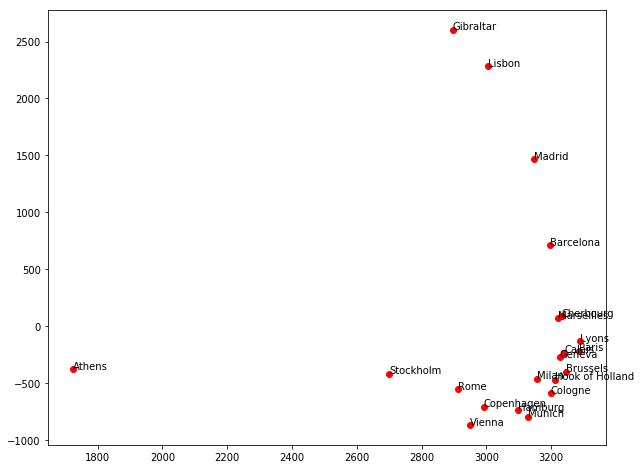

In [6]:
eurocity_dataframe = pd.read_csv('eurodist.csv', index_col=0, header=0)
citynames = eurocity_dataframe.columns
X_embedded = MDS(eurocity_dataframe.as_matrix(), 2)
plt.figure(figsize=(10, 8))
for i in range(21):
    plt.plot(X_embedded[i,0], X_embedded[i,1], 'or')
    plt.text(X_embedded[i,0], X_embedded[i,1], citynames[i])

### c)


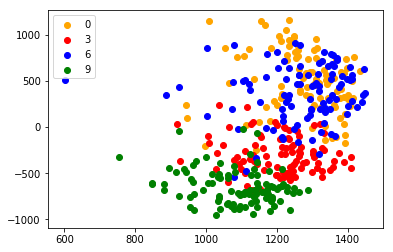

In [7]:
train_df = pd.read_csv('USPS.csv', sep='\t',)
X = train_df.drop(['Label'], axis=1).as_matrix()
y = train_df['Label'].as_matrix()
idx = np.any([y == 0, y == 3, y == 6, y == 9], axis=0)
X = X[idx]
y = y[idx]

uspsmds = MDS(euclidean_distances(X, X), 2)
fig, ax = plt.subplots()
color = ['orange' if l == 0 else 'red' if l == 3 else 'b' if l == 6 else 'g' for l in y]
cols = ['orange', 'red','blue','green']
for k in range(len(cols)):
    ax.scatter(uspsmds[y==k*3,0], uspsmds[y==k*3,1], c=cols[k], label=str(k*3))
ax.legend()
plt.show()

# Exercise 3)

### a)

In [11]:
def isomap(D,kn,d):
    p=np.partition(D, kn,axis=-1)
    p=p[:,kn]#kth most closer distances
    W=np.max(D)-D#similarity matrix
    p=np.max(D)-p#kth highest similarities
    W=W.T
    W[W<=p]=0.0
    W=W.T#now W has only the kth most similar vertices with similarity values above 0, the other values are set to 0
    W[W<=p]=0.0#doing the same also for the distances from the columns to the rows###
    knnM=np.max(D)-W###now the distances that are not the k closest ones, are set to the max distance value
    G=nx.Graph(knnM)
    klen=nx.all_pairs_dijkstra_path_length(G)
    listklen=list(klen)
    
    keys=np.vectorize(dict.keys)(np.array(listklen)[:, 1])
    f=np.vectorize(list, otypes=[list])
    keys=f(keys)
    keyM=np.array(list(keys))
    
    values=np.vectorize(dict.values)(np.array(listklen)[:, 1])
    f=np.vectorize(list, otypes=[list])
    values=f(values)
    valueM=np.array(list(values))
    
    
    orderedindex=np.argsort(keyM)
    Geo=valueM[np.arange(np.shape(valueM)[0])[:,np.newaxis], orderedindex]#Geodesic Distances, lowest path lenghts from pi to pj
    return MDS(Geo, d)

### b)

isomap(euclidean_distances(X, X), 5, 2)
isomap(euclidean_distances(X, X), 5, 1)
isomap(euclidean_distances(X, X), 20, 2)
isomap(euclidean_distances(X, X), 20, 1)
isomap(euclidean_distances(X, X), 50, 2)
isomap(euclidean_distances(X, X), 50, 1)
finished


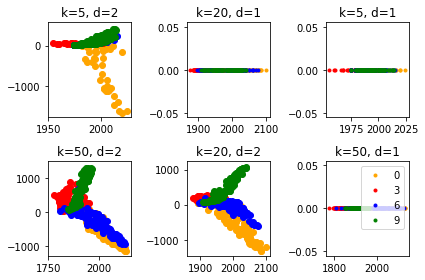

In [12]:
print("isomap(euclidean_distances(X, X), 5, 2)")
z = np.zeros(len(X))
k = [5, 20, 50]
cols = ['orange', 'red','blue','green']
fig = plt.figure()
ax = fig.add_subplot(2,3,1)
for i in range(len(cols)):
    l = isomap(euclidean_distances(X, X), 5, 2)
    ax.scatter(l[y==i*3,0], l[y==i*3,1], color=cols[i], label=str(i*3))
    ax.set_title('k=5, d=2')
print("isomap(euclidean_distances(X, X), 5, 1)")
ax = fig.add_subplot(2,3,3)
for i in range(len(cols)):
    l = isomap(euclidean_distances(X, X), 5, 1)
    ax.plot(l[y==i*3], z[y==i*3], '.', color=cols[i], label=str(i*3))
    ax.set_title('k=5, d=1')
print("isomap(euclidean_distances(X, X), 20, 2)")    
ax = fig.add_subplot(2,3,5)
for i in range(len(cols)):
    l = isomap(euclidean_distances(X, X), 20, 2)
    ax.scatter(l[y==i*3,0], l[y==i*3,1], color=cols[i], label=str(i*3))
    ax.set_title('k=20, d=2')
print("isomap(euclidean_distances(X, X), 20, 1)")
ax = fig.add_subplot(2,3,2)
for i in range(len(cols)):
    l = isomap(euclidean_distances(X, X), 20, 1)
    ax.plot(l[y==i*3], z[y==i*3], '.', color=cols[i], label=str(i*3))
    ax.set_title('k=20, d=1')
print("isomap(euclidean_distances(X, X), 50, 2)")
ax = fig.add_subplot(2,3,4)
for i in range(len(cols)):
    l = isomap(euclidean_distances(X, X), 50, 2)
    ax.scatter(l[y==i*3,0], l[y==i*3,1], color=cols[i], label=str(i*3))
    ax.set_title('k=50, d=2')
print("isomap(euclidean_distances(X, X), 50, 1)")
ax = fig.add_subplot(2,3,6)
for i in range(len(cols)):
    l = isomap(euclidean_distances(X, X), 50, 1)
    ax.plot(l[y==i*3], z[y==i*3], '.', color=cols[i], label=str(i*3))
    ax.set_title('k=50, d=1')
print("finished")
ax.legend()
plt.tight_layout()
plt.show()